<b><div style="text-align:right">Алексей Бебчик&nbsp;&nbsp;</div><b>
### Курс 6. Желтое такси. Неделя 4. Прогнозирование ряда со сложной сезонностью  
(задание, оцениваемое сокурсниками)




### Часть 3. Прогноз поездок и расчет метрики качества

<a href="https://www.coursera.org/learn/data-analysis-project/peer/zp6d0/proghnozirovaniie-bol-shogho-kolichiestva-riadov">Задание</a>

6.Для каждой из $R$ географических зон настройте на данных __до апреля 2016__ включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу:    

$Q_{may} =\frac1{R* 739* 6} \sum\limits_{r=1}^{R} \sum_{T=2016.04.30\,23:00}^{2016.05.31\,17:00} \sum_{i=1}^6 \left| \hat{y}^r_{T|T+i} - y_{T+i}^r \right|.$  

7.Для каждой из $R$ географических зон настройте на данных __до мая 2016__ включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. 

Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

__Внимание!__ Пользовалтельские функции определены в конце файла. Пожалуйста, пройдите вниз файла, выполните __"Блок определения пользовательских функций"__, затем вернитесь продолжите с этого места.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import binned_statistic_2d
import os                                     #для проверки существования файлов
import statsmodels.api as sm
from sklearn import linear_model
import datetime as dt
import timeit as ti
from  statsmodels.tsa.arima_model import ARIMAResults
%pylab inline

Populating the interactive namespace from numpy and matplotlib


__ Подготовка данных__

Загрузим уже агрерированные данные за 2016 год (файл с таким именем прилагается к работе)

In [4]:
data_path = '..\\YTData\\' #путь к папке с данными

In [5]:
#Имя файла с данными для формирования и загрузки
reg_fname = data_path + 'regions.csv'
w4_fname  = data_path + 'YTw4_tripdata_2016' #K6_w4_tripdata_2016
w4_fname_data = w4_fname + '_data.csv'

In [6]:
cload = True
if cload==True: 
    data_all = pd.read_csv(w4_fname_data, parse_dates=['dt_hour'], dayfirst=True) #Загружаем подготовленные данные из файла
else: #Готовим данные с сохраняем в файл
    data_all = load_prepare_save_data(save_fname=w4_fname_data, reg_fname=reg_fname, month_count=6) 

In [18]:
print data_all.region.unique().shape[0] #102 района

102


In [19]:
#Создадим структуру для накопления данных в разрезе регионов (только те, которые будем прогнозировать)
data_reg = pd.DataFrame(data_all.region.unique(), columns=['region']) 

In [20]:
data_all['fold'] = 0 #определим фолды для обучения ("1-до мая" и "2-с мая до июня")
data_all.loc[data_all.dt_hour < dt.datetime(2016,6,1), 'fold'] = 2 #Фолд 2 (предсказание)
data_all.loc[data_all.dt_hour < dt.datetime(2016,5,1), 'fold'] = 1 #Фолд 1 (предсказание + настройка параметров модели)
print 'Размер Фолда 1', data_all[(data_all.fold <> 0) & (data_all.fold <= 1)].shape[0]
print 'Размер Фолда 2', data_all[(data_all.fold <> 0) & (data_all.fold <= 2)].shape[0]

Размер Фолда 1 296208
Размер Фолда 2 372096


In [21]:
data_all.set_index('dt_hour', drop=False, inplace=True) #восстанавливаем индекс на основе Даты-времени
data_all.index.name = 'dt_index' 

In [22]:
data_all['day'] = data_all.dt_hour.dt.floor('D') #выделим отдельно день
data_all['weekday'] = data_all.dt_hour.dt.dayofweek

w_cols = ['w_precip', 'w_snow_fall', 'w_avg_temp'] #столбцы погоды
df_weather = pd.read_csv(data_path + 'weather_data_nyc_centralpark_2016(1).csv', parse_dates=['date'], dayfirst=True)
df_weather.rename(columns={u'date':u'day'}, inplace=True)
#Т.к. минимальное ненулевое значение 0.01, а T- это trace, "след", то поставим ему 0.001 (больше 0, меньше 0.01)
df_weather['snow fall']     = df_weather['snow fall'].apply(lambda x: 0.001 if x == 'T' else float(x))
df_weather['precipitation'] = df_weather['precipitation'].apply(lambda x: 0.001 if x == 'T' else float(x))
#Добавим столбцы с погодой
data_all['w_snow_fall'] = np.array(pd.merge(data_all, df_weather, how='inner', on=['day'])['snow fall'])
data_all['w_avg_temp']  = np.array(pd.merge(data_all, df_weather, how='inner', on=['day'])['average temperature'])
data_all['w_precip']    = np.array(pd.merge(data_all, df_weather, how='inner', on=['day'])['precipitation']).astype(float)
#Нормализация (от 0 до 1), не используем scale, т.к. отрицательные значения нам не нужны, их нет в sin и cos
#Вообще это не совсем правильная нормализация, нужно настроить Transformer и применятьь для прогноза уже его,
#или также заново нормализовывать данные для прогноза
data_all['w_snow_fall'] = np.array(data_all['w_snow_fall']) /np.array(data_all['w_snow_fall']).max().astype(float)
data_all['w_precip'   ] = np.array(data_all['w_precip'   ]) /np.array(data_all['w_precip'   ]).max().astype(float)
data_all['w_avg_temp' ] = np.array(data_all['w_avg_temp' ]) /np.array(data_all['w_avg_temp' ]).max().astype(float)

__Формируем дополнительные признаки для учета недельной сезонности__

$s_i = \sin \left( [1,\dots,T] * 2 \pi i/ 168 \right), c_i = \cos \left( [1,\dots,T] * 2 \pi i/ 168 \right), i=1,\dots, K.$

В __Задании 3__ был проанализированы разные значения $K$ и было принято решения взять __$K$__=__6__  

In [23]:
lr_K    = 6 #6 - оптимальное значение числа признаков, как было выяснено в Задании 3
lr_cols = []
for i in range(1,lr_K+1):
    lr_cols.append('s'+str(i))
    lr_cols.append('c'+str(i))

rows_range = np.arange(1, len(data_all)+1)
for i in range(1,lr_K+1):
    data_all['s'+str(i)] = sin(rows_range*2*math.pi*i/168.0)
    data_all['c'+str(i)] = cos(rows_range*2*math.pi*i/168.0)

#Добавим столбцы, которые нам потом понадобятся
for col in ['lr_trips', 'lr_resid', 'lr_resid_diff24', 'lr_resid_diff24_1',
            'pred_trips0', 'pred_trips', 'pred_resid']: data_all[col] = 0

__Загружаем данные кластеризации__ (выполнена ранее, файл "Part1_Clustering")

In [24]:
reg_clust_all = pd.read_csv(w4_fname+'_reg_clust.csv', sep=',') #считаем из файлоа
reg_clust_one = reg_clust_all[reg_clust_all.one==1].sort_values(by='label').reset_index(drop=True)[['label','region']]
#проставим номер кластера в данных о поездках для обучения и в данных с тестовой частью
data_all['one_clust'] = np.array(data_all.merge(reg_clust_one, how ='left', on = ['region']).label.fillna(0), int)
data_all['reg_clust'] = np.array(data_all.merge(reg_clust_all, how ='left', on = ['region']).label.fillna(0), int)
#кластеры для списке регионов
data_reg['reg_clust'] = np.array(data_reg.merge(reg_clust_all, how ='left', on = ['region']).label.fillna(0), int)
data_reg['one_clust'] = np.array(data_reg.merge(reg_clust_one, how ='left', on = ['region']).label.fillna(0), int)

In [25]:
#Формируем структуры для параметров модели и загружаем данные__</center>
clust_list = list(sorted(data_reg.reg_clust.unique()))

cNF_cols     = ['cN','cF', 'cNF']
prmsPDQ_cols = ['cN', 'p', 'd', 'q', 'P', 'D', 'Q', 'done', 'aic', 'time', 'expect', 'exp_time', 'exp_aic']
fitPDQ_cols  = ['cN', 'p', 'd', 'q', 'P', 'D', 'Q', 'done', 'aic', 'time', 'expect', 'exp_time', 'exp_aic', 'L']
modPrms_cols = ['cN','cF','cNF', 'prm_name','prm_value']
predH6_cols  = ['cN','cF','cNF', 'region', 'num', 'dt_start', 'done', 'time', 'H1','H2','H3','H4','H5','H6']
pred_cols    = ['cN','cF','cNF', 'region', 'num', 'dt_start', 'done', 'time', 'hour_num',
                'pred_trips0', 'dt_hour', 'pred_trips', 'real_trips', 'delta_trips', 'delta_trips_abs']
reg_cols     = ['region','reg_clust','one_clust', 'done', 'Q']
answer_cols  = cNF_cols + ['answer_id','answer_trips']

prmsPDQ  = pd.DataFrame(columns = prmsPDQ_cols)
fitPDQ   = pd.DataFrame(columns = fitPDQ_cols)
modPrms  = pd.DataFrame(columns = modPrms_cols)
predH6   = pd.DataFrame(columns = predH6_cols)
pred     = pd.DataFrame(columns = pred_cols)
reg      = pd.DataFrame(columns = reg_cols)
answer   = pd.DataFrame(columns = answer_cols)

In [27]:
# Загружаем уже рассчитанные ранее данные и выбранные параметры модели
for cNi in clust_list[:]:
   
    f_prmsPDQ  = w4_fname+'_c'+str(cNi) +'_prmsPDQ'   #подбор параметров (только для первого фолдера)
    if os.path.exists(f_prmsPDQ) == True:
        tmp_prmsPDQ = pd.read_csv(f_prmsPDQ, sep=',') #из отдельных файлов
        prmsPDQ = pd.concat([prmsPDQ, tmp_prmsPDQ])   #prmsPDQ.drop_duplicates(inplace=True) #если загрузили два раза случайно

    f_fitPDQ  = w4_fname+'_c'+str(cNi) +'_fitPDQ' #подбор параметров (только для первого фолдера)
    if os.path.exists(f_fitPDQ) == True:
        tmp_fitPDQ = pd.read_csv(f_fitPDQ, sep=',') #из отдельных файлов
        tmp_fitPDQ['L'] = 24 
        fitPDQ = pd.concat([fitPDQ, tmp_fitPDQ])   #prmsPDQ.drop_duplicates(inplace=True) #если загрузили два раза случайно

    #два фолдера
    for cFi in range(1,3):

        cNFi = cpX(cNi, cFi)

        modPrms_fname = w4_fname+'_c'+str(cNFi)+'_mod_prms' #параметры обученной модели
        if os.path.exists(modPrms_fname) == True:
            tmp_Prms = pd.read_csv(modPrms_fname, sep=',', header=None)
            tmp_Prms.columns = ['prm_name', 'prm_value']
            tmp_Prms['cN']  = cNi
            tmp_Prms['cF']  = cFi
            tmp_Prms['cNF'] = cNFi
            modPrms = pd.concat([modPrms, tmp_Prms])
        else: print 'no file "' + modPrms_fname + '"'

        predH6_fname = w4_fname+'_c'+str(cNFi)+'_pred_h6'  #предсказанные данные в формате столбцов
        if os.path.exists(predH6_fname) == True:
            tmp_predH6 = pd.read_csv(predH6_fname, sep=',', parse_dates=['dt_start'])
            predH6 = pd.concat([predH6, tmp_predH6])
        else: print 'no file "' + predH6_fname + '"'

        pred_fname = w4_fname+'_c'+str(cNFi)+'_pred.csv' #предсказанные данные, разложенные по датам
        if os.path.exists(pred_fname) == True:
            tmp_pred = pd.read_csv(pred_fname, sep=',', parse_dates=['dt_start', 'dt_hour']) 
            tmp_pred['cN']  = cNi
            tmp_pred['cF']  = cFi
            tmp_pred['cNF'] = cNFi
            pred = pd.concat([pred, tmp_pred])
        else: print 'no file "' + pred_fname + '"'

        reg_fname = w4_fname+'_c'+str(cNFi)+'_reg.csv'
        if os.path.exists(reg_fname) == True:
            tmp_reg = pd.read_csv(reg_fname, sep=',')  #регионы, их кластеры, качество предсказания
            reg = pd.concat([reg, tmp_reg])
        else: print 'no file "' + reg_fname + '"'

        answer_fname = w4_fname+'_c'+str(cNFi)+'_answer.csv' #ответы (столбцы cN, cF, cFN для загрузки ответа не нужны)
        if os.path.exists(answer_fname) == True:
            tmp_answer = pd.read_csv(answer_fname, sep=',', header=None) 
            tmp_answer.columns = ['answer_id','answer_trips']
            tmp_answer['cN']  = cNi
            tmp_answer['cF']  = cFi
            tmp_answer['cNF'] = cNFi
            answer = pd.concat([answer, tmp_answer])
        else: print 'no file "' + answer_fname + '"'

prmsPDQ = prmsPDQ[prmsPDQ_cols]
for c in ['cN', 'p', 'd', 'q', 'P', 'D', 'Q', 'done']: prmsPDQ[c] = prmsPDQ[c].astype(int)
fitPDQ = fitPDQ[fitPDQ_cols]
for c in ['cN', 'p', 'd', 'q', 'P', 'D', 'Q', 'done', 'L']: fitPDQ[c] = fitPDQ[c].astype(int)
modPrms = modPrms[modPrms_cols]
for c in cNF_cols: modPrms[c] = modPrms[c].astype(int)
predH6 = predH6[predH6_cols]
for c in cNF_cols+['region','done','num']: predH6[c] = predH6[c].astype(int)
pred = pred[pred_cols]
for c in cNF_cols+['region','done','num']: pred[c] = pred[c].astype(int)
reg = reg[reg_cols]
for c in ['region','reg_clust','one_clust','done']: reg[c] = reg[c].astype(int)
    
answer = answer[answer_cols]
for c in cNF_cols+['answer_trips']: answer[c] = answer[c].astype(int)

<center>__ПРОГНОЗ__</center>

__ПРИНЦИП:__
Всегда обучаем одну модель для одного набора данных (Кластер + Фолд 1/Фолд2). Результаты обучения записываем в файл. Финальный разбор полетов проводим отдельно, загружая все файлы в единую структуру

Задаем нужные параметры: __cN__ - номер кластера, __cF__ - номер фолда, выполням расчет (много часов, с перерывами), меняем параметры и опять запускаем расчет, так 10 раз, для 5 кластеров по два фолда.   
Нужно было бы автоматизировать выбор и кластера и фолда из списка необработанных, но "руки не дошли".

__Фолд 1__ Для каждой из  $R$  географических зон настройте на данных __до апреля 2016 включительно__ модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд.
__Фолд 2__ Для каждой из $R$ географических зон настройте на данных __до мая 2016 включительно__ модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд.

In [21]:
cN  = 5          #номер кластера
cF  = 1          #номер фолдера (набора данных для пронозирования)
cNF = cpX(cN,cF) #номер кластера + Номер фолда
if cF == 1:      #даты для прогноза разных Фолдов
    cpred_beg = pd.datetime(2016,4,30, 23, 0) #начальная дата прогноза (Фолд 1)
    cpred_end = pd.datetime(2016,5,31, 17, 0) #конечная дата прогноза  (Фолд 1)
else: 
    cpred_beg = pd.datetime(2016,5,31, 23, 0) #начальная дата прогноза  (Фолд 2)
    cpred_end = pd.datetime(2016,6,30, 17, 0) #конечная дата прогноза   (Фолд 2)

print 'cN {}, cF {}, cNF {}, диапазон {}-{}'.format(cN, cF, cNF, cpred_beg, cpred_end)

cN 5, cF 1, cNF 51, диапазон 2016-04-30 23:00:00-2016-05-31 17:00:00


__Надо переписывать на унифицированную структуру с одним файлом на кластер__

In [22]:
#Все по ВСЕМ датам и по ВСЕМ регионам
cXall = data_all[data_all.reg_clust == cN]
#Данные ОДНОГО региона и ОДНОГО фолдера
cX    = data_all[(data_all.one_clust == cN) & (data_all.fold <> 0) & (data_all.fold <= cF)]
#Все районы кластера 

In [23]:
#копируем данные, потом будем вставлять обратно
cXreg    = data_reg[data_reg.reg_clust == cN].copy().reset_index()
cXpredH6 = predH6[predH6.cNF == cNF].copy().reset_index()

__Считываем параметры, подобранные для данного Кластера и Фолда__

In [24]:
if fitPDQ[fitPDQ.cN==cN].shape[0] > 0:
    cPDQ = fitPDQ[fitPDQ.cN==cN][['p','d','q','P','D','Q','L']].astype(int).to_dict(orient='index').values()[0]
else: print 'нет данных по кластеру ', cN

In [25]:
print cNF, cPDQ

51 {'Q': 0, 'd': 0, 'P': 2, 'L': 24, 'q': 0, 'p': 11, 'D': 1}


In [26]:
if modPrms[modPrms.cNF==cNF].shape[0] > 0: 
    cload = True
    print 'Загружаем данные Кластер_Фолд', cNF
else: cload = False

Загружаем данные Кластер_Фолд 51


In [27]:
cmod_fname     = w4_fname+'_c'+str(cNF)+'_mod'          #модель
cmodPrms_fname = w4_fname+'_c'+str(cNF)+'_mod_prms'     #параметры обученной модели
cpredH6_fname  = w4_fname+'_c'+str(cNF)+'_pred_h6'      #предсказанные данные в формате столбцов
cpred_fname    = w4_fname+'_c'+str(cNF)+'_pred.csv'     #предсказанные данные, разложенные по датам
creg_fname     = w4_fname+'_c'+str(cNF)+'_reg.csv'      #регионы, их кластеры, качество предсказания
cansw_fname    = w4_fname+'_c'+str(cNF)+'_answer.csv'   #ответы (столбцы cN, cF, cFN для загрузки ответа не нужны)

Обучаем модель __для выбранного Фолда__ (или считываем уже готовую)

In [28]:
if os.path.exists(cmodPrms_fname) == True:
    cload = True
    print 'Загружаем данные Кластер_Фолд', cNF
else: cload = False

Загружаем данные Кластер_Фолд 51


In [128]:
%%time
cmod = ARIMAResults                                  #SARIMAX для предсказания

cload = True
if cload == False: #Создаем и обучаем модель для данного Кластера и Фолда
    caic, cmod = fit_sarimax(cX, cPDQ['p'], cPDQ['d'], cPDQ['q'], cPDQ['P'], cPDQ['D'], cPDQ['Q'], LAG=24, trend='n')  
    cmod.params.to_csv(cmodPrms_fname)  #сохраняем параметры модели
    cmod_params = cmod.params           #для удобства скидываем параметры в локальную переменную
else: #Или Загружаем уже обученную модель из файла
    caic        = 0                                #не записываем AIC в файлы
    cmod        = ARIMAResults                     #SARIMAX для прогноза
    cmod_params = pd.Series(index = modPrms[modPrms.cNF==cNF].prm_name, 
                            data  = np.array(modPrms[modPrms.cNF==cNF].prm_value))
    cmod_params.index.name = ''              #сбрасываем имя индекса
    cmod_params = cmod_params.T.squeeze()    #преобразуем DataFrame в Series (модель только так принимает)    

Wall time: 2 ms


In [40]:
# Посмотрим на параметры
print 'order ({},{},{})'.format(cPDQ['p'],cPDQ['d'],cPDQ['q']), 
print 'seasonal ({},{},{},{})'.format(cPDQ['P'],cPDQ['D'],cPDQ['Q'],cPDQ['L'])

order (11,0,0) seasonal (2,1,0,24)


In [30]:
#Проставим признак обработанных данных
cXreg['done'] = 0 
cXreg.loc[cXreg.region.isin(np.unique(cXpredH6.region)), 'done'] = 1

In [133]:
print 'Приблизительно 15 минут один район, т.к. весь кластер около {} ч.'.format(cXreg.shape[0]*15 /60.)

Приблизительно 15 минут один район, т.к. весь кластер около 6.75 ч.


__Строим прогноз Кластера по Всем районам__

In [31]:
cXreg.groupby(['done'], as_index=False).done.size() #посмотрим, сколько уже спрогнозировано, и сколько осталось

done
1    27
dtype: int64

По завершении прогноза должно быть __только__ строка с __done=1__

In [42]:
%%time

reg_count = 6 #количество районов (т.к. считается долго, ставим немного, 4 района - где-то час)
step      = 0
wall_len  = 0

for i, r in cXreg[(cXreg.done==0)].sort_values(by=['region'])[:reg_count].iterrows(): #перебираем районы 
    step += 1
   
    cRegNum  = int(r.region)                  #очередной район
    cXallReg = cXall[cXall.region==cRegNum]   #и его данные
   
    t = ti.default_timer()                    #старт прогнозирования района
   
   
    cpredH6 = get_sarimax_predH6(m_cNF=cNF, m_RegNum=cRegNum, #m_count=1000,  #всего около 15 минут на район
        m_mod_params = cmod_params, m_PDQ = cPDQ, m_dt_all = cXallReg, date_beg=cpred_beg, date_end=cpred_end,
        say_each=100) 

    #удаляем прежние результаты (если они были) 
    cXpredH6.drop(cXpredH6[cXpredH6.region==cRegNum].index, axis=0, inplace=True, errors='ignore') 
    
    cXpredH6 = pd.concat([cXpredH6, cpredH6])            #подстыковываем новые данные
    
    cXpredH6.to_csv(cpredH6_fname, index=False)         #сохраняем резульаты прогноза (ВСЕ районы)
    
    cXreg.loc[(cXreg.region == cRegNum), 'done'] = 1    #ставим флаг выполнения прогноза по району    
    
    t1 = ti.default_timer()         #завершение прогнозирования района

    step_len  = round((t1-t)/60.,2) #длительность прогнозирования района
    wall_len += step_len            #суммарная длительность прогнозирования

print 'Прогнозирование завершено за {:.2f}м.'.format(wall_len)

In [32]:
cXpredH6.head(2)

,index,cN,cF,cNF,region,num,dt_start,done,time,H1,H2,H3,H4,H5,H6
0,0,5,1,51,1076,0,2016-04-30 23:00:00,1,0.01,75.069356,53.318778,44.815548,36.089163,13.585407,23.376581
1,1,5,1,51,1076,1,2016-05-01 00:00:00,1,0.01,49.450868,43.471132,36.238097,14.071624,24.119450,53.237601


In [136]:
cXpredH6.drop('index', axis=1, inplace=True) #удаляем индекс, он нам не нужен

In [33]:
cXpredH6.region.unique() #спрогнозированные районы

array([1076, 1077, 1132, 1181, 1183, 1184, 1234, 1235, 1279, 1280, 1283,
       1284, 1285, 1286, 1287, 1331, 1332, 1333, 1334, 1335, 1336, 1337,
       1383, 1384, 1385, 1386, 1434], dtype=int64)

__Теперь надо преобразовать данные, записать их в файл и посчитать метрику__

In [36]:
cXpred = get_XpredOnH6(cXpredH6) #Разворачивает таблицу, чтобы значения я предсказанных данных попали из столбцов в строки

In [37]:
#Сформируем данные о реальных поездках в прогнозируемый период в разрезе каждого Региона и Конца истории (dt_start)
cXpredReal = pd.merge(cXpred[['dt_start','dt_hour','region']], cXall[['dt_hour','region','trips']],
         how='inner', on=['dt_hour','region']).sort_values(by=['dt_hour'])[['dt_start','dt_hour','region', 'trips']]
#Присоединим данные о реальных поездках к каждому концу истории и дате в рамках него
cXpred['real_trips']      = pd.merge(cXpred, cXpredReal, how='inner', on=['dt_start','dt_hour','region'])['trips']
cXpred['delta_trips']     = cXpred['pred_trips'] - cXpred['real_trips']
cXpred['delta_trips_abs'] = cXpred['delta_trips'].abs()

In [70]:
cXpred.to_csv(cpred_fname, index=False) #сохраним в файле

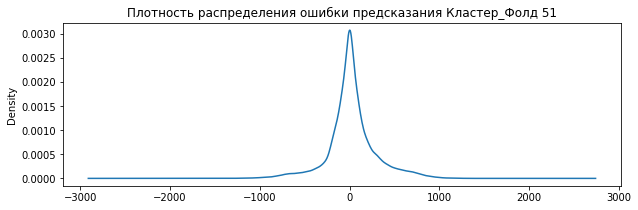

In [39]:
plt.figure(figsize=(10,3))
cXpred.delta_trips.plot(kind='kde', title=u'Плотность распределения ошибки предсказания Кластер_Фолд '+str(cNF))

Посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
$Q_{may} =\frac1{R* 739* 6} \sum\limits_{r=1}^{R} \sum_{T=2016.04.30\,23:00}^{2016.05.31\,17:00} \sum_{i=1}^6 \left| \hat{y}^r_{T|T+i} - y_{T+i}^r \right|.$  


In [41]:
# Разложим метрику по районам (теоретически можно анализировать зависимость Q по дальности района до ценра кластера)
cXreg.loc[:, 'Q'] = 0.0
cXpred.loc[:, 'region'] = cXpred.region.astype(int, inplace=True)

cXregQ = cXpred.groupby('region', as_index=False).delta_trips_abs.sum()
cXregQ['region'] = cXregQ.region.astype(int)
if cF==1:
    cXregQ['pred_Q'] = cXregQ.delta_trips_abs/(739.*6.) #для первого фолда 739 значений на район
else: 
    cXregQ['pred_Q'] = cXregQ.delta_trips_abs/(715.*6.) #для первого фолда 715 значений на район

cXreg = cXreg.reset_index(drop=True)
cXreg.loc[:, 'Q'] = pd.merge(cXreg, cXregQ, how='left', on=['region']).pred_Q.fillna(0)

In [79]:
cXreg.to_csv(creg_fname, index=False) #сохраним в файле

In [141]:
cQ = sum(cXreg.Q)/(cXreg[cXreg.done==1].shape[0])

In [111]:
print 'Метрика Q (Кластер {}, Фолд {}): {:.2f}'.format(cN, cF, cQ)

Метрика Q (Кластер 4, Фолд 1): 30.57


После перебора всех кластеров и фолдов и сохранения параметров в файлы переходим
на файл __Part4_Final__

__Блок определения пользовательских функций__

In [17]:
#Получает датасет с набором дат для предсказания, выполняет предсказание и сохраняет результыт в файл
def get_XpredOnH6(m_predH6m):
    #Разворачиваем таблицу, чтобы значения я предсказанных данных попали из столбцов (так было легче сохранять в файл) в строки
    m_Xpred = pd.melt(m_predH6m.reset_index(), 
            id_vars    = ['dt_start','cN', 'cF','cNF', 'region', 'num', 'done', 'time'], 
            value_vars = ['H1','H2','H3','H4','H5','H6'],
            var_name   = 'hour_num', 
            value_name = 'pred_trips0').sort_values(by=['dt_start','hour_num']).reset_index(drop=True)
    #Преобразуем значение Hx в столбце hour_num в количество частов смещения hour_num.apply(lambda x:x[-1:]), 
    #а затем в реальную дату
    m_Xpred['dt_hour']    = m_Xpred.dt_start + m_Xpred.hour_num.apply(lambda x:pd.Timedelta(hours=int(x[-1:])))
    m_Xpred['pred_trips'] = m_Xpred.pred_trips0.round(0).astype(int) #округляем остатки
    m_Xpred.loc[m_Xpred['pred_trips'] < 0 , 'pred_trips'] = 0        #и заменяем отрицательные значения на нули 

    return m_Xpred

#Получает датасет с набором дат для предсказания, выполняет предсказание и сохраняет результыт в файл
def get_sarimax_predH6(m_cNF, m_RegNum, m_mod_params, m_PDQ, m_dt_all, 
                       date_beg, date_end, verbose=True, say_each=None, conf_int=False):
    m_step      = 0 
    m_wall_len  = 0

    m_H6 = pd.DataFrame(columns = ['dt_start'], data = pd.date_range(date_beg, date_end, freq='H')) #даты для прогноза
    m_H6['num' ]   = m_H6.index           #индекс для перебора дат
    m_H6['region'] = cRegNum              #район 
    m_H6['cNF']    = cNF                  #КластерФолд
    m_H6['cN']     = int(str(m_cNF)[:1 ]) #Кластер
    m_H6['cF']     = int(str(m_cNF)[-1:]) #Фолд

    m_H6_count     = m_H6.shape[0]        #число записей для прогноза (одинаковое для всех кластеров, районов и фолдов)

    #информация о начале расчета
    if verbose == True: print u'Район {}, начало в {}, записей {}'.format(
        m_RegNum, dt.datetime.now().strftime('%H:%M:%S'), m_H6_count)
    
    #модель для предсказания (на основе подобранных параметров для кластера)
    m_model = sm.tsa.statespace.SARIMAX(m_dt_all.trips,
                                        order=(m_PDQ['p'],m_PDQ['d'],m_PDQ['q']),
                                        seasonal_order=(m_PDQ['P'],m_PDQ['D'],m_PDQ['Q'],m_PDQ['L']), 
                                        exog = m_dt_all[lr_cols]).filter(m_mod_params)

    #информация об обучении модели
    if verbose == True: print u'Модель настроена {}'.format(dt.datetime.now().strftime('%H:%M:%S'))

    #перебираем прогнозируемые даты
    for i, r in m_H6.sort_values(by=['num'], ascending=True).iterrows():

        m_step += 1
        m_t = ti.default_timer()                         #время начала
       
        m_time_beg = (r.dt_start + pd.Timedelta(hours=1)).to_pydatetime() 
        m_time_end = (r.dt_start + pd.Timedelta(hours=6)).to_pydatetime()
        
        #готовим внешние данные на для дополнительной регрессии в модели
        m_exog0 = m_dt_all[lr_cols].loc[(m_dt_all.dt_hour>m_time_beg) & (m_dt_all.dt_hour<=m_time_end)] 

        #выполняем прогноз
        if conf_int == True:
            m_predict = m_model.get_prediction(start=str(m_time_beg), end=str(m_time_end), exog=m_exog0, dynamic=True)
            m_predict_mean = m_predict.predicted_mean #получаем среднее значение (интервалы пока не считываем)
        else:
            m_predict_mean = m_model.predict(start=str(m_time_beg), end=str(m_time_end), exog=m_exog0, dynamic=True)
        
        m_step_len = round((ti.default_timer()-m_t)/60.,2) #длительность обучения
        m_wall_len  += m_step_len                          #суммарная длительность обучения  

        #сохраняем полученные значения
        m_H6_index = m_H6[(m_H6.num==r.num)].index       #индекс текущей строки в общем наборе параметров
        m_H6.loc[m_H6_index, 'done'] = 1                 #признак обработанной строки
        m_H6.loc[m_H6_index, 'time'] = m_step_len        #сохраняем длительность выполнения
        m_H6.loc[m_H6_index, 'H1']   = m_predict_mean[0] #проноз на 1 час   вперед
        m_H6.loc[m_H6_index, 'H2']   = m_predict_mean[1] #проноз на 2 часа  вперед
        m_H6.loc[m_H6_index, 'H3']   = m_predict_mean[2] #проноз на 3 часа  вперед
        m_H6.loc[m_H6_index, 'H4']   = m_predict_mean[3] #проноз на 4 часа  вперед
        m_H6.loc[m_H6_index, 'H5']   = m_predict_mean[4] #проноз на 5 часов вперед
        m_H6.loc[m_H6_index, 'H6']   = m_predict_mean[5] #проноз на 6 часов вперед
        
        if verbose == True and (say_each == None or m_step % say_each == 0): 
            print u'{} ({}мин) '.format(m_step, m_wall_len), #m_step_len

    #информация о завершении расчета
    if verbose == True: print u'Район {}, завершение в {} ({:.2f}ч)'.format(
        m_RegNum, dt.datetime.now().strftime('%H:%M:%S'), m_wall_len/60.)

    #возвращаем данные
    return m_H6


def fit_sarimax(dt, p, d, q, P, D, Q, LAG=24, simple_diff=False, stationar=False, invert=False, trend=None):    

    warnings.filterwarnings('ignore')

    try: #try except нужен, потому что на некоторых наборах параметров модель не обучается

        model=sm.tsa.statespace.SARIMAX(dt.trips.astype(float),
                                        order=(p, d, q), 
                                        #в доп. признаках учтем погоду, хотя это кардинально и не помогло
                                        exog                  = dt[lr_cols], # + weather_cols], 
                                        seasonal_order        = (P, D, Q, LAG),
                                        simple_differencing   = simple_diff, 
                                        enforce_stationarity  = stationar, 
                                        enforce_invertibility = invert,
                                        trend                 = trend 
                                       ).fit(disp=-1)

    #выводим параметры, на которых модель не обучается и переходим к следующему набору         
    except ValueError as e:
        print 'wrong parameters:',  (p, d, q, P, D, Q), e
        return (0, None) 

    warnings.filterwarnings('default')

    return (model.aic, model) 

def cpX(m_cN, m_cP): return int(str(m_cN)+str(m_cP))    

def print_time(label='now'):
    print label, dt.datetime.now().strftime('%H:%M')
    
#Готовим данные и записываем их в файл (примерно 6 минут да 2016 год)
def load_prepare_save_data(save_fname, month_count, reg_fname='regions.csv', 
                           cut_regLess5 = True, save_data=True, return_data=True):
    
    #Координаты квадрата Нью_Йорка
    west_ny, east_ny, south_ny, north_ny  = -74.25559,-73.700018, 40.49612, 40.91553
    
    #Загружаем районы и получаем границы корзин
    regs = pd.read_csv(reg_fname, sep=';') 
    binx  = sorted(set(regs.west.value_counts().index)  | set(regs.east.value_counts().index ))
    biny  = sorted(set(regs.south.value_counts().index) | set(regs.north.value_counts().index))
    
    
    # Составим список файлов для обработки
    files = ['yellow_tripdata_2016-' + ('0'+str(x+1))[-2:] + '.csv' for x in range(month_count)]# [:1] для отладкаи 5

    #Загрузим данные, ограничив их по району, количеству пассажиров и продолжительности поездки
    data_cols = ['tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count',
                 'trip_distance','pickup_longitude','pickup_latitude'] 

    dfmon_list = []
    for f in files:
        print_time('read '+ f)
        dfmon = pd.read_csv(f, sep=',', parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'], usecols=data_cols) 

        del_index = dfmon[(dfmon.tpep_pickup_datetime == dfmon.tpep_dropoff_datetime) #Нулевая длительность
                    | (dfmon['passenger_count' ] == 0)          # поездки с нулевым количеством пассажиров
                    | (dfmon['trip_distance'   ] == 0)          # поездки с нулевым расстоянием поездки по счётчику
                    | (dfmon['pickup_longitude'] <  west_ny)    # поездки, не попадающие в прямоугольник Нью-Йорка
                    | (dfmon['pickup_longitude'] >= east_ny)    
                    | (dfmon['pickup_latitude' ] <  south_ny)   
                    | (dfmon['pickup_latitude' ] >= north_ny)  
                         ].index

        dfmon.drop(del_index, inplace=True)
        dfmon['dt_hour'] = dfmon.tpep_pickup_datetime.dt.floor('H') #день и час (.dt.hour - только час)
        #Разобъем данные на квадраты
        r_bins = binned_statistic_2d(
            x = dfmon.pickup_longitude, 
            y = dfmon.pickup_latitude, 
            values = None, 
            statistic = 'count', 
            bins      = [binx, biny],
            range     = [[-74.25559, -73.70001], [40.49612, 40.91553]], expand_binnumbers = True)
        # Вычислим номер региона
        bin_regs = np.array([(x-1) * 50 + y for x, y in zip(*r_bins.binnumber)])
        #print_time('set regs')
        dfmon['region']  = bin_regs
        #print_time('aggregate')
        dfmon_agr = dfmon.groupby(['dt_hour', 'region'], as_index=False).pickup_longitude.count()
        dfmon_agr.columns = ['dt_hour', 'region', 'trips']
        dfmon_list.append(dfmon_agr)

    data_trips = pd.concat(dfmon_list) #только совершенные поездки в регионах

    #---- надо добавить нули для регионов и часов, в которых не было поездок

    #все регионы
    regions  = pd.DataFrame(regs.region, columns=['region'])
    regions['key'] = 0 #для cross join в merge 

    #все дни и часы за весь период в данных
    start_date  = data_trips.dt_hour.min() #дата начала данных
    end_date    = data_trips.dt_hour.max() #дата окончания данных
    dt_hours = pd.DataFrame(pd.date_range(start_date, end_date, freq='H').values, columns=['dt_hour'])
    dt_hours['key'] = 0 #для cross join в merge 

    #все дни и часы для каждого региона (cross join)
    data_hr = pd.merge(regions, dt_hours, how='outer')[['dt_hour','region']]

    #добавим столбец с количеством поездок для каждой пары с помощью left join, заполнив NaN нулями
    data_hr['trips'] = data_hr.merge(data_trips, how='left', on = ['dt_hour', 'region']).fillna(0).trips.astype(int)

    #Подсчитываем среднее число поездок в час (по данным за май 2016, согласно 2-му заданию, оставляем 102 района)
    if cut_regLess5 == True:
        data_hr_mean = data_hr[(data_hr.dt_hour.dt.year==2016)&
                               (data_hr.dt_hour.dt.month==5)].groupby('region', as_index=False)['trips'].mean()
        regs_less5 = data_hr_mean[data_hr_mean.trips<5].region.values           #районы, где среднее число поездок меньше 5
        data_hr.drop(data_hr[data_hr.isin({'region':regs_less5}).region ].index, inplace=True) #удаляем данные этих районов

    #сохраняем файл
    if save_data == True and save_fname <> '':
        data_hr.to_csv(save_fname, index=False)

    if return_data == True:
        return data_hr